<a href="https://colab.research.google.com/github/prajwalpai/Upgrad-Assignments/blob/main/SO_Assignment-complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stack Overflow EDA on cloud Assignment

## Import libs

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules 
import pymysql
from sqlalchemy import create_engine
import warnings
import datetime
import numpy as np
warnings.filterwarnings('ignore')

## Read Data from AWS S3

In [ ]:
qns = pd.read_csv("https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Questions.csv", encoding = "latin1")
ans = pd.read_csv("https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Answers.csv", encoding = "latin1")
tags = pd.read_csv("https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Tags.csv", encoding = "latin1")
users = pd.read_csv("https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Users.csv" , encoding = "latin1")

## Check Basic Info of data

 

### Check Shape

In [ ]:
qns.shape

(1264216, 7)

In [ ]:
qns.sample()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
1049867,34458930,681266.0,2015-12-24T23:55:03Z,NaN,0,Most efficient way to increment a value of eve...,<p>Say I have entries that look like this:</p>...


In [ ]:
ans.shape

(2014516, 6)

In [ ]:
ans.sample()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
633014,11259290,1234840.0,2012-06-29T09:29:02Z,11259070,0,<p>You can also use Date.parse function</p>\n\...


In [ ]:
tags.shape

(3750994, 2)

In [ ]:
tags.sample()

,Id,Tag
2055328,23851830,join


In [ ]:
users.shape

(1990480, 9)

### Check Sample 

In [ ]:
users.sample()

,Unnamed: 0,id,display_name,creation_date,last_access_date,reputation,up_votes,down_votes,views
442372,442372,151292,James McNellis,2009-08-05 19:01:38.793 UTC,2019-08-30 17:05:32.333 UTC,296237,1888,656,34033


## Cleanup Data


### Remove Null

#### Remove null OwnerUserId in qns

In [ ]:
qns = qns[~qns['OwnerUserId'].isnull()]

In [ ]:
qns.isnull().sum()

Id                    0
OwnerUserId           0
CreationDate          0
ClosedDate      1194522
Score                 0
Title                 0
Body                  0
dtype: int64

#### Remove null OwnerUserId in ans

In [ ]:
ans = ans[~ans['OwnerUserId'].isnull()]

In [ ]:
ans.isnull().sum()

Id              0
OwnerUserId     0
CreationDate    0
ParentId        0
Score           0
Body            0
dtype: int64

#### Remove null Tags in tags

In [ ]:
tags = tags[~tags['Tag'].isnull()]

In [ ]:
tags.isnull().sum()

Id     0
Tag    0
dtype: int64

In [ ]:
users.isnull().sum()

Unnamed: 0            0
id                    0
display_name        136
creation_date         0
last_access_date      0
reputation            0
up_votes              0
down_votes            0
views                 0
dtype: int64

#### Remove null display_name in users

In [ ]:
users = users[~users['display_name'].isnull()]

In [ ]:
users['id'].value_counts()

22656      3270
1144035    3009
29407      2144
548225     1924
115145     1813
           ... 
5588787       1
4138147       1
1417000       1
1427235       1
4098          1
Name: id, Length: 465436, dtype: int64

### Remove unnecessary Data

#### Remove "Unnamed: 0" column from users

In [ ]:
users.drop('Unnamed: 0', axis=1, inplace= True)

#### Remove the duplicate rows from users

In [ ]:
users.drop_duplicates(inplace = True)

In [ ]:
users.isnull().sum()

id                  0
display_name        0
creation_date       0
last_access_date    0
reputation          0
up_votes            0
down_votes          0
views               0
dtype: int64

In [ ]:
users

,id,display_name,creation_date,last_access_date,reputation,up_votes,down_votes,views
0,26,Shawn,2008-08-01 12:18:14.52 UTC,2018-04-11 04:40:35.66 UTC,11820,565,67,3547
27,1109,Theo,2008-08-12 12:16:58.61 UTC,2019-08-31 11:39:52.28 UTC,116072,457,136,6905
85,364174,stats,2010-06-11 03:34:57.137 UTC,2019-08-29 18:37:35.027 UTC,325,25,1,60
87,61,Bernard,2008-08-01 14:21:00.573 UTC,2019-08-30 07:11:58.297 UTC,22779,1321,219,1731
97,20709,Black Horus,2008-09-22 20:03:39.71 UTC,2019-09-01 01:17:38.133 UTC,978,73,2,96
...,...,...,...,...,...,...,...,...
1990475,4228492,Michael Spranger,2014-11-07 20:21:14.283 UTC,2019-08-28 18:01:29.56 UTC,415,112,2,17
1990476,6820506,Manuela,2016-09-12 00:19:17.83 UTC,2018-07-20 01:28:24.853 UTC,21,38,0,50
1990477,4464432,YTorii,2015-01-17 10:48:17.523 UTC,2019-08-31 13:51:47.413 UTC,336,67,1,13
1990478,4605946,space_voyager,2015-02-25 13:43:24.63 UTC,2019-07-13 23:55:47.607 UTC,884,53,1,191


#### Remove the duplicate rows from Qns ( Same Questions)

In [ ]:
qns.drop_duplicates(inplace = True)

### Standardise Numbers

In [ ]:
qns.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


#### Making OwnerUserId an integer

In [ ]:
qns['OwnerUserId'] = qns['OwnerUserId'].astype(int)

In [ ]:
ans['OwnerUserId'] = ans['OwnerUserId'].astype(int)

In [ ]:
qns.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [ ]:
ans.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
1,124,26,2008-08-01T16:09:47Z,80,12,<p>I wound up using this. It is a kind of a ha...
2,199,50,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...
3,269,91,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur..."
4,307,49,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article..."


In [ ]:
qns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1249762 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   Id            1249762 non-null  int64 
 1   OwnerUserId   1249762 non-null  int64 
 2   CreationDate  1249762 non-null  object
 3   ClosedDate    55240 non-null    object
 4   Score         1249762 non-null  int64 
 5   Title         1249762 non-null  object
 6   Body          1249762 non-null  object
dtypes: int64(3), object(4)
memory usage: 76.3+ MB


In [ ]:
tags.shape

(3749881, 2)

#### Change the Dates Columns type to DateType.

In [ ]:
qns['CreationDate'] = pd.to_datetime(qns['CreationDate'])
ans['CreationDate'] = pd.to_datetime(ans['CreationDate'])

## Handling outliers 

### Outliers in Score in Questions/qns

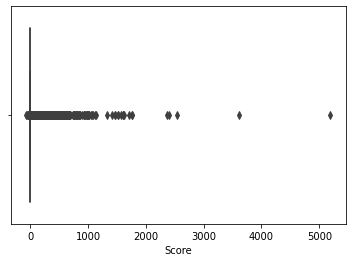

In [ ]:
sns.boxplot(qns.Score)

In [ ]:
qns = qns[qns.Score < 1200]

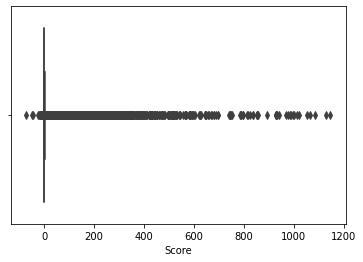

In [ ]:
sns.boxplot(qns.Score)

In [ ]:
qns.Score.describe()

count    1.249744e+06
mean     1.741049e+00
std      1.070463e+01
min     -7.300000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.147000e+03
Name: Score, dtype: float64

### Outliers in Score in Answers/ans

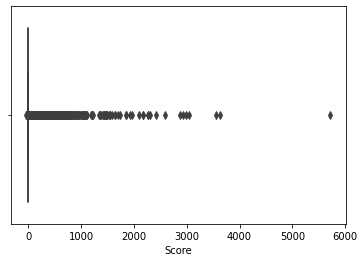

In [ ]:
sns.boxplot(ans.Score)

In [ ]:
ans = ans[ans.Score < 1100]

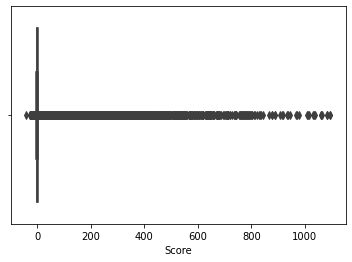

In [ ]:
sns.boxplot(ans.Score)

In [ ]:
ans.Score.describe()

count    2.001268e+06
mean     2.434043e+00
std      1.221149e+01
min     -4.200000e+01
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.095000e+03
Name: Score, dtype: float64

### Outliers in reputation in Users/users

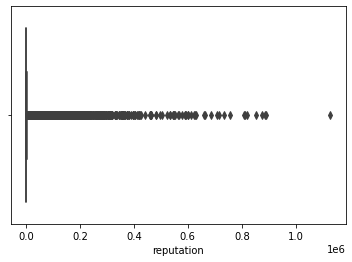

In [ ]:
sns.boxplot(users.reputation)

In [ ]:
users = users[users.reputation < 600000]

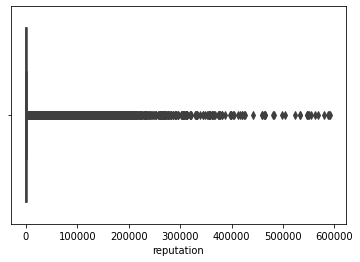

In [ ]:
sns.boxplot(users.reputation)

In [ ]:
users

,id,display_name,creation_date,last_access_date,reputation,up_votes,down_votes,views
0,26,Shawn,2008-08-01 12:18:14.52 UTC,2018-04-11 04:40:35.66 UTC,11820,565,67,3547
27,1109,Theo,2008-08-12 12:16:58.61 UTC,2019-08-31 11:39:52.28 UTC,116072,457,136,6905
85,364174,stats,2010-06-11 03:34:57.137 UTC,2019-08-29 18:37:35.027 UTC,325,25,1,60
87,61,Bernard,2008-08-01 14:21:00.573 UTC,2019-08-30 07:11:58.297 UTC,22779,1321,219,1731
97,20709,Black Horus,2008-09-22 20:03:39.71 UTC,2019-09-01 01:17:38.133 UTC,978,73,2,96
...,...,...,...,...,...,...,...,...
1990475,4228492,Michael Spranger,2014-11-07 20:21:14.283 UTC,2019-08-28 18:01:29.56 UTC,415,112,2,17
1990476,6820506,Manuela,2016-09-12 00:19:17.83 UTC,2018-07-20 01:28:24.853 UTC,21,38,0,50
1990477,4464432,YTorii,2015-01-17 10:48:17.523 UTC,2019-08-31 13:51:47.413 UTC,336,67,1,13
1990478,4605946,space_voyager,2015-02-25 13:43:24.63 UTC,2019-07-13 23:55:47.607 UTC,884,53,1,191


## Prepping Join/Merge 


In [ ]:
qns.head()

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26,2008-08-01 13:57:07+00:00,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58,2008-08-01 14:41:24+00:00,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83,2008-08-01 15:50:08+00:00,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740,2008-08-01 18:42:19+00:00,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91,2008-08-01 23:22:08+00:00,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [ ]:
qns.rename(columns={'Id':'Q_Id', 'OwnerUserId':'Q_OwnerUserId', 'CreationDate':'Q_CreationDate','ClosedDate':'Q_ClosedDate' }, inplace=True)
qns.rename(columns={'Score':'Q_Score', 'Title':'Q_Title', 'Body':'Q_Body' }, inplace=True)

### Renaming Questions columns with Q identifier

In [ ]:
qns.head()

,Q_Id,Q_OwnerUserId,Q_CreationDate,Q_ClosedDate,Q_Score,Q_Title,Q_Body
0,80,26,2008-08-01 13:57:07+00:00,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58,2008-08-01 14:41:24+00:00,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83,2008-08-01 15:50:08+00:00,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740,2008-08-01 18:42:19+00:00,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91,2008-08-01 23:22:08+00:00,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [ ]:
ans.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61,2008-08-01 14:45:37+00:00,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
1,124,26,2008-08-01 16:09:47+00:00,80,12,<p>I wound up using this. It is a kind of a ha...
2,199,50,2008-08-01 19:36:46+00:00,180,1,<p>I've read somewhere the human eye can't dis...
3,269,91,2008-08-01 23:49:57+00:00,260,4,"<p>Yes, I thought about that, but I soon figur..."
4,307,49,2008-08-02 01:49:46+00:00,260,28,"<p><a href=""http://www.codeproject.com/Article..."


###  Renaming Answers columns with A identifier

In [ ]:
ans.rename(columns={'Id':'A_Id', 'OwnerUserId':'A_OwnerUserId', 'CreationDate':'A_CreationDate' }, inplace=True)
ans.rename(columns={'ParentId':'Q_Id','Score':'A_Score', 'Body':'A_Body' }, inplace=True)

In [ ]:
ans.sample()

,A_Id,A_OwnerUserId,A_CreationDate,Q_Id,A_Score,A_Body
1075770,20062999,2184055,2013-11-19 04:07:37+00:00,20062970,2,<p>Put <code>vertical-align: bottom</code> on ...


In [ ]:
qns.sample()

,Q_Id,Q_OwnerUserId,Q_CreationDate,Q_ClosedDate,Q_Score,Q_Title,Q_Body
1041236,34223310,4921299,2015-12-11 12:13:42+00:00,NaN,1,Misprinting Statement of Invoices,<p>First of all apologies if I'm not asking th...


### Cosolidating Tags as CSV values grouped by Question ID 

**Breaking up the below commented line to make sure processor is NOT taxed**

**Note :** Had initiatlly tested with tags.head(5000) and worked well but running on entire dataframe execution almost made jupyter unresponsive.

In [ ]:
#tags.groupby(['Id'])['Tag'].apply(lambda Tag: ''.join(Tag.to_string(index=False))).str.replace('(\\n)', ',').reset_index()

In [ ]:
tags2 = tags.groupby(['Id'])['Tag']

In [ ]:
tags3 = tags2.apply(lambda Tag: ''.join(Tag.to_string(index=False)))

In [ ]:
tags3.str.replace('(\\n)', ',').reset_index()

,Id,Tag
0,80,"flex, actionscript-3, air"
1,90,"svn, tortoisesvn,..."
2,120,"sql, asp.net, sitemap"
3,180,"algorithm, language-agnostic, ..."
4,260,"c#, .net,..."
...,...,...
1264209,40143210,"php, .htaccess"
1264210,40143300,google-bigquery
1264211,40143340,"android, android-studio"
1264212,40143360,"javascript, vue.js"


In [ ]:
tags=tags3.str.replace('(\\n)', ',').reset_index()

In [ ]:
tags

,Id,Tag
0,80,"flex, actionscript-3, air"
1,90,"svn, tortoisesvn,..."
2,120,"sql, asp.net, sitemap"
3,180,"algorithm, language-agnostic, ..."
4,260,"c#, .net,..."
...,...,...
1264209,40143210,"php, .htaccess"
1264210,40143300,google-bigquery
1264211,40143340,"android, android-studio"
1264212,40143360,"javascript, vue.js"


In [ ]:
tags.rename(columns={'Id':'Q_Id'}, inplace= True)

In [ ]:
tags

,Q_Id,Tag
0,80,"flex, actionscript-3, air"
1,90,"svn, tortoisesvn,..."
2,120,"sql, asp.net, sitemap"
3,180,"algorithm, language-agnostic, ..."
4,260,"c#, .net,..."
...,...,...
1264209,40143210,"php, .htaccess"
1264210,40143300,google-bigquery
1264211,40143340,"android, android-studio"
1264212,40143360,"javascript, vue.js"


In [ ]:
users

,id,display_name,creation_date,last_access_date,reputation,up_votes,down_votes,views
0,26,Shawn,2008-08-01 12:18:14.52 UTC,2018-04-11 04:40:35.66 UTC,11820,565,67,3547
27,1109,Theo,2008-08-12 12:16:58.61 UTC,2019-08-31 11:39:52.28 UTC,116072,457,136,6905
85,364174,stats,2010-06-11 03:34:57.137 UTC,2019-08-29 18:37:35.027 UTC,325,25,1,60
87,61,Bernard,2008-08-01 14:21:00.573 UTC,2019-08-30 07:11:58.297 UTC,22779,1321,219,1731
97,20709,Black Horus,2008-09-22 20:03:39.71 UTC,2019-09-01 01:17:38.133 UTC,978,73,2,96
...,...,...,...,...,...,...,...,...
1990475,4228492,Michael Spranger,2014-11-07 20:21:14.283 UTC,2019-08-28 18:01:29.56 UTC,415,112,2,17
1990476,6820506,Manuela,2016-09-12 00:19:17.83 UTC,2018-07-20 01:28:24.853 UTC,21,38,0,50
1990477,4464432,YTorii,2015-01-17 10:48:17.523 UTC,2019-08-31 13:51:47.413 UTC,336,67,1,13
1990478,4605946,space_voyager,2015-02-25 13:43:24.63 UTC,2019-07-13 23:55:47.607 UTC,884,53,1,191


In [ ]:
ans.sample()

,A_Id,A_OwnerUserId,A_CreationDate,Q_Id,A_Score,A_Body
454216,7952983,467868,2011-10-31 11:18:46+00:00,7850650,0,<p>rails integration tests should be written s...


In [ ]:
qns.sample()

,Q_Id,Q_OwnerUserId,Q_CreationDate,Q_ClosedDate,Q_Score,Q_Title,Q_Body
1227401,39228720,2508465,2016-08-30 13:22:21+00:00,NaN,0,Scala Linq alternative,<p>I'm trying to re-write an application from ...


In [ ]:
tags.sample()

,Q_Id,Tag
582632,20111730,"entity-framework, ef-code-first,..."


In [ ]:
users.sample()

,id,display_name,creation_date,last_access_date,reputation,up_votes,down_votes,views
920414,773702,Josh,2011-05-27 20:17:47.513 UTC,2019-08-29 17:54:41.973 UTC,6964,2793,124,607


## Merging Questions, Answers and Tags to get a consolidated DataFrame

In [ ]:
qna = pd.merge(qns,ans,how='inner', on='Q_Id')

In [ ]:
final_df = pd.merge(qna,tags,how='inner', on='Q_Id')

In [ ]:
final_df.sample()

,Q_Id,Q_OwnerUserId,Q_CreationDate,Q_ClosedDate,Q_Score,Q_Title,Q_Body,A_Id,A_OwnerUserId,A_CreationDate,A_Score,A_Body,Tag
577595,9383450,152873,2012-02-21 18:58:07+00:00,NaN,27,How can I detect Heroku's environment?,"<p>I have a Django webapp, and I'd like to che...",19184024,1530754,2013-10-04 14:38:32+00:00,13,"<p>Similar to what Neil suggested, I would do ...","python, django, deployment, h..."


In [ ]:
users.sample()

,id,display_name,creation_date,last_access_date,reputation,up_votes,down_votes,views
1906222,2260657,GeraOd,2013-04-09 07:47:16.71 UTC,2019-06-20 12:55:05.46 UTC,1,0,0,8


In [ ]:
tags1 = tags.head(5000)

## Filtering the DataFrame to select only DataScience Tagges Queries/Answers

ds_tags = Data Science Tags provided in the Assignment Objectives

In [ ]:
ds_tags=['python', 'r', 'matlab', 'sas', 'excel', 'sql']

In [ ]:
final_df = final_df[final_df.Tag.astype(str).str.contains(pat="python|matlab|sas|excel|sql|r,")]

In [ ]:
final_df = final_df.reset_index(drop=True)

In [ ]:
final_df.sample()

,Q_Id,Q_OwnerUserId,Q_CreationDate,Q_ClosedDate,Q_Score,Q_Title,Q_Body,A_Id,A_OwnerUserId,A_CreationDate,A_Score,A_Body,Tag
68180,6240860,558423,2011-06-05 03:39:22+00:00,NaN,3,Model classes -- what the heck do they really ...,<p>I really can't seem to get the hang of Mode...,6241240,643383,2011-06-05 05:48:25+00:00,6,<p>You absolutely <em>can</em> work with dicti...,"objective-c, ios,..."


In [ ]:
users.sample()

,id,display_name,creation_date,last_access_date,reputation,up_votes,down_votes,views
1637551,3638363,DougWare,2014-05-14 20:28:39.627 UTC,2014-06-09 14:32:24.91 UTC,131,0,0,11


## Droping off unnessary columns

In [ ]:
Cleaned_up_df = final_df[['Q_Id','Q_CreationDate','A_CreationDate','A_Id', 'A_OwnerUserId','A_Score','Tag']]

In [ ]:
Cleaned_up_df

,Q_Id,Q_CreationDate,A_CreationDate,A_Id,A_OwnerUserId,A_Score,Tag
0,120,2008-08-01 15:50:08+00:00,2008-09-23 22:41:11+00:00,124363,12734,9,"sql, asp.net, sitemap"
1,580,2008-08-02 23:30:59+00:00,2008-08-02 23:40:04+00:00,585,149,13,"sql-server, sql-server-2005, ..."
2,580,2008-08-02 23:30:59+00:00,2008-08-02 23:51:09+00:00,586,34,17,"sql-server, sql-server-2005, ..."
3,580,2008-08-02 23:30:59+00:00,2008-08-03 00:22:03+00:00,590,116,2,"sql-server, sql-server-2005, ..."
4,580,2008-08-02 23:30:59+00:00,2008-08-03 00:37:03+00:00,591,111,3,"sql-server, sql-server-2005, ..."
...,...,...,...,...,...,...,...
388241,40142380,2016-10-19 22:13:40+00:00,2016-10-19 23:15:05+00:00,40142998,6942565,0,"python, unix, split"
388242,40142550,2016-10-19 22:28:58+00:00,2016-10-19 22:38:05+00:00,40142640,4104224,1,"mysql, sql, left-join"
388243,40142860,2016-10-19 23:01:07+00:00,2016-10-19 23:14:50+00:00,40142994,1951885,0,"excel, excel-formula"
388244,40143190,2016-10-19 23:36:01+00:00,2016-10-19 23:38:17+00:00,40143212,1491895,5,"python, bash, multiline"


## Draw Maps for each of the Data Science Tag

In [ ]:
map_dict={}
for tag in ds_tags:
  print(f"Processing {tag}")
  map_dict[tag] = Cleaned_up_df[Cleaned_up_df.Tag.astype(str).str.contains(pat=tag)]['A_OwnerUserId'].value_counts()[:10].sort_values()

Processing python
Processing r
Processing matlab
Processing sas
Processing excel
Processing sql


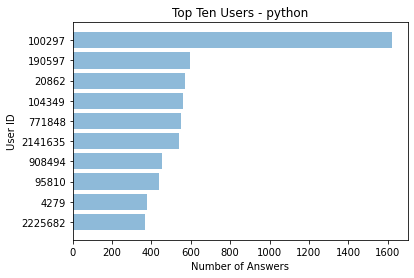

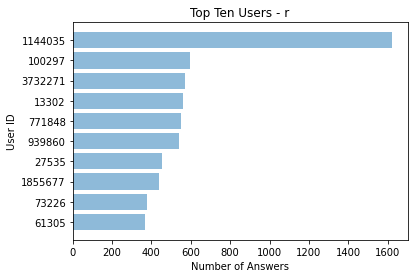

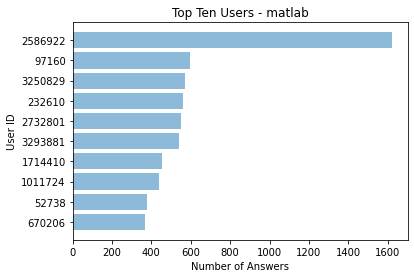

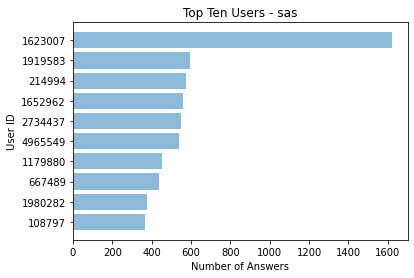

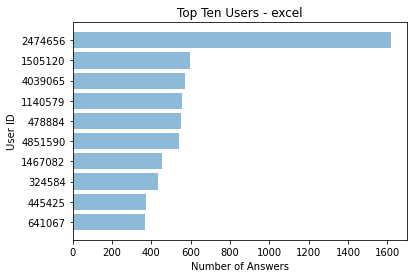

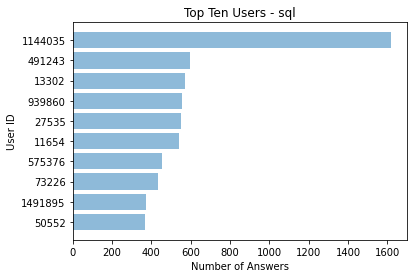

In [ ]:
for tag in ds_tags:
  useridlist = [str(int) for int in map_dict[tag].index]
  plt.barh(useridlist, list(map_dict['python']), align='center', alpha=0.5)
  plt.ylabel("User ID") 
  plt.xlabel("Number of Answers") 
  plt.title('Top Ten Users - '+tag)
  plt.show()

In [ ]:
Cleaned_up_df['Response_time'] = Cleaned_up_df['A_CreationDate'] - Cleaned_up_df['Q_CreationDate']

In [ ]:
Cleaned_up_df

,Q_Id,Q_CreationDate,A_CreationDate,A_Id,A_OwnerUserId,A_Score,Tag,Response_time
0,120,2008-08-01 15:50:08+00:00,2008-09-23 22:41:11+00:00,124363,12734,9,"sql, asp.net, sitemap",53 days 06:51:03
1,580,2008-08-02 23:30:59+00:00,2008-08-02 23:40:04+00:00,585,149,13,"sql-server, sql-server-2005, ...",0 days 00:09:05
2,580,2008-08-02 23:30:59+00:00,2008-08-02 23:51:09+00:00,586,34,17,"sql-server, sql-server-2005, ...",0 days 00:20:10
3,580,2008-08-02 23:30:59+00:00,2008-08-03 00:22:03+00:00,590,116,2,"sql-server, sql-server-2005, ...",0 days 00:51:04
4,580,2008-08-02 23:30:59+00:00,2008-08-03 00:37:03+00:00,591,111,3,"sql-server, sql-server-2005, ...",0 days 01:06:04
...,...,...,...,...,...,...,...,...
388241,40142380,2016-10-19 22:13:40+00:00,2016-10-19 23:15:05+00:00,40142998,6942565,0,"python, unix, split",0 days 01:01:25
388242,40142550,2016-10-19 22:28:58+00:00,2016-10-19 22:38:05+00:00,40142640,4104224,1,"mysql, sql, left-join",0 days 00:09:07
388243,40142860,2016-10-19 23:01:07+00:00,2016-10-19 23:14:50+00:00,40142994,1951885,0,"excel, excel-formula",0 days 00:13:43
388244,40143190,2016-10-19 23:36:01+00:00,2016-10-19 23:38:17+00:00,40143212,1491895,5,"python, bash, multiline",0 days 00:02:16


## Find ID of Top 5 users who have answered most questions 

## Find 50perentile and 75perentile Response time for each of Data Science Tag

In [ ]:
top5_dict={}
for tag in ds_tags:
  print(f"Processing {tag}")
  top5_dict[tag] = {}
  userid_list =  Cleaned_up_df[Cleaned_up_df.Tag.astype(str).str.contains(pat=tag)]['A_OwnerUserId'].value_counts()[:5]
  useridlist_str = [str(int) for int in userid_list.index]
  top5_dict[tag]['useridlst'] = ','.join(useridlist_str)
  top5_dict[tag]['resp-50'] = Cleaned_up_df[Cleaned_up_df.Tag.astype(str).str.contains(pat=tag)].groupby(['Q_Id']).min()['Response_time'].describe()[5]
  top5_dict[tag]['resp-75'] = Cleaned_up_df[Cleaned_up_df.Tag.astype(str).str.contains(pat=tag)].groupby(['Q_Id']).min()['Response_time'].describe()[6]


Processing python
Processing r
Processing matlab
Processing sas
Processing excel
Processing sql


In [ ]:
top5_dict

{'excel': {'resp-50': Timedelta('0 days 00:37:56.500000'),
  'resp-75': Timedelta('0 days 03:05:28.250000'),
  'useridlst': '2474656,1505120,4039065,1140579,478884'},
 'matlab': {'resp-50': Timedelta('0 days 00:37:42.500000'),
  'resp-75': Timedelta('0 days 03:11:01'),
  'useridlst': '2586922,97160,232610,3250829,2732801'},
 'python': {'resp-50': Timedelta('0 days 00:20:11'),
  'resp-75': Timedelta('0 days 02:24:26'),
  'useridlst': '100297,190597,20862,104349,771848'},
 'r': {'resp-50': Timedelta('0 days 00:27:04'),
  'resp-75': Timedelta('0 days 03:47:01.750000'),
  'useridlst': '1144035,100297,3732271,13302,771848'},
 'sas': {'resp-50': Timedelta('0 days 01:49:45'),
  'resp-75': Timedelta('0 days 15:24:12'),
  'useridlst': '1623007,1919583,214994,2734437,1652962'},
 'sql': {'resp-50': Timedelta('0 days 00:13:34'),
  'resp-75': Timedelta('0 days 01:03:58.750000'),
  'useridlst': '1144035,491243,13302,939860,27535'}}

In [ ]:
rowlist=[]
col1=[]
col2=[]
col3=[]

for tag in ds_tags:
  rowlist.append(tag)
  col1.append(top5_dict[tag]['useridlst'])
  col2.append(top5_dict[tag]['resp-50'])
  col3.append(top5_dict[tag]['resp-75'])



In [ ]:
rowlist

['python', 'r', 'matlab', 'sas', 'excel', 'sql']

In [ ]:
col2

[Timedelta('0 days 00:20:11'),
 Timedelta('0 days 00:27:04'),
 Timedelta('0 days 00:37:42.500000'),
 Timedelta('0 days 01:49:45'),
 Timedelta('0 days 00:37:56.500000'),
 Timedelta('0 days 00:13:34')]

In [ ]:

Final_Results = pd.DataFrame(
    {'Top 5 Users who can answer': col1,
     '50%-Response-time (mins)': col2,
     '75%-Response-time (mins)': col3
    },index=rowlist)

In [ ]:
Final_Results

,Top 5 Users who can answer,50%-Response-time (mins),75%-Response-time (mins)
python,"100297,190597,20862,104349,771848",0 days 00:20:11,0 days 02:24:26
r,"1144035,100297,3732271,13302,771848",0 days 00:27:04,0 days 03:47:01.750000
matlab,"2586922,97160,232610,3250829,2732801",0 days 00:37:42.500000,0 days 03:11:01
sas,"1623007,1919583,214994,2734437,1652962",0 days 01:49:45,0 days 15:24:12
excel,"2474656,1505120,4039065,1140579,478884",0 days 00:37:56.500000,0 days 03:05:28.250000
sql,"1144035,491243,13302,939860,27535",0 days 00:13:34,0 days 01:03:58.750000


In [ ]:
Final_Results['50%-Response-time (mins)'] = Final_Results['50%-Response-time (mins)'].astype('timedelta64[m]')
Final_Results['75%-Response-time (mins)'] = Final_Results['75%-Response-time (mins)'].astype('timedelta64[m]')


In [ ]:
Final_Results

,Top 5 Users who can answer,50%-Response-time (mins),75%-Response-time (mins)
python,"100297,190597,20862,104349,771848",20.0,144.0
r,"1144035,100297,3732271,13302,771848",27.0,227.0
matlab,"2586922,97160,232610,3250829,2732801",37.0,191.0
sas,"1623007,1919583,214994,2734437,1652962",109.0,924.0
excel,"2474656,1505120,4039065,1140579,478884",37.0,185.0
sql,"1144035,491243,13302,939860,27535",13.0,63.0


# Objective 3 ; Predict use of better Tags ; Using Apriori on Tags! 


Reading Data of Tags from scratch

In [ ]:
data = pd.read_csv("https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Tags.csv", encoding = "latin1")

In [ ]:
data['Tag'] = data['Tag'].astype('str')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


In [ ]:
data['Tag'].unique


<bound method Series.unique of 0                    flex
1          actionscript-3
2                     air
3                     svn
4             tortoisesvn
                ...      
3750989        javascript
3750990            vue.js
3750991               npm
3750992             mocha
3750993             babel
Name: Tag, Length: 3750994, dtype: object>

**Note : There is 3750994 unique tags, so Filtering only the Data Science relevan tags**

---



---



##Filtering Data Science tagged Data

In [ ]:
data_filtered = data[data['Tag'].str.contains(pat="python|matlab|sas|excel|sql|r,")]

In [ ]:
len(data_filtered['Tag'].unique())

652

##Prepping the Data for Apriori

In [ ]:
data_for_apriori = data_filtered.groupby(['Id','Tag'])['Tag'].count().unstack().reset_index().fillna(0).set_index('Id')

data_for_apriori.head(10)

Tag,activepython,alasql,android-sql,android-sqlite,ansi-sql,apache-spark-sql,applescript-excel,arrow-python,azure-sql-database,azure-sql-reporting,azure-sql-server,azure-sqldw,backup-sqldatabase,bigsql,biopython,boost-python,bootstrap-sass,bpython,breakpoint-sass,cefpython,cocos2d-python,compass-sass,couchdb-python,cpython,createprocessasuser,disassembler,disassembling,disassembly,disaster-recovery,django-mssql,django-mysql,django-postgresql,dmx-ssas,dnspython,dronekit-python,dynamic-sql,ef-postgresql,embedded-sql,encrypted-core-data-sql,entity-sql,...,sqlpackage,sqlparameter,sqlparameters,sqlperformance,sqlplus,sqlprofileprovider,sqlprofiler,sqlproj,sqlps,sqlresultsetmapping,sqlroleprovider,sqlsiphon,sqlsoup,sqlsrv,sqltransaction,sqlvarchar,sqlworkflowpersistencese,sqlx,sqlxml,sqlyog,squirrel-sql,ssas,ssas-2008,ssas-2008-r2,ssas-2012,ssas-tabular,susy-sass,system.data.sqlite,tsql,tsql-parser,tsql-sequence,tsqlt,u-sql,vim-ipython,vpython,vsql,web-sql,winsql,wxpython,xquery-sql
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
data_for_apriori

Tag,activepython,alasql,android-sql,android-sqlite,ansi-sql,apache-spark-sql,applescript-excel,arrow-python,azure-sql-database,azure-sql-reporting,azure-sql-server,azure-sqldw,backup-sqldatabase,bigsql,biopython,boost-python,bootstrap-sass,bpython,breakpoint-sass,cefpython,cocos2d-python,compass-sass,couchdb-python,cpython,createprocessasuser,disassembler,disassembling,disassembly,disaster-recovery,django-mssql,django-mysql,django-postgresql,dmx-ssas,dnspython,dronekit-python,dynamic-sql,ef-postgresql,embedded-sql,encrypted-core-data-sql,entity-sql,...,sqlpackage,sqlparameter,sqlparameters,sqlperformance,sqlplus,sqlprofileprovider,sqlprofiler,sqlproj,sqlps,sqlresultsetmapping,sqlroleprovider,sqlsiphon,sqlsoup,sqlsrv,sqltransaction,sqlvarchar,sqlworkflowpersistencese,sqlx,sqlxml,sqlyog,squirrel-sql,ssas,ssas-2008,ssas-2008-r2,ssas-2012,ssas-tabular,susy-sass,system.data.sqlite,tsql,tsql-parser,tsql-sequence,tsqlt,u-sql,vim-ipython,vpython,vsql,web-sql,winsql,wxpython,xquery-sql
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40142550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40142600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40142840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

## Applying the apriori module
Note : Since this is just 1/3 of the objective , Using the module instead of implemting from scratch

In [ ]:
frq_items = apriori(data_for_apriori, min_support = 0.005, use_colnames = True)

In [ ]:
frq_items

,support,itemsets
0,0.055648,(excel)
1,0.027883,(excel-vba)
2,0.007186,(linq-to-sql)
3,0.034807,(matlab)
4,0.227566,(mysql)
5,0.009973,(mysqli)
6,0.007508,(plsql)
7,0.031838,(postgresql)
8,0.346199,(python)
9,0.030884,(python-2.7)


In [ ]:
so_rules = association_rules(frq_items, metric ="lift", min_threshold = .5) 
so_rules =so_rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
so_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
27,"(sql, tsql)",(sql-server),0.011774,0.097320,0.008114,0.689122,7.080989,0.006968,2.903643
8,(python-3.x),(python),0.022626,0.346199,0.015461,0.683325,1.973796,0.007628,2.064585
1,(excel-vba),(excel),0.027883,0.055648,0.018510,0.663848,11.929378,0.016958,2.809298
7,(python-2.7),(python),0.030884,0.346199,0.019989,0.647232,1.869541,0.009297,1.853349
19,(tsql),(sql-server),0.022283,0.097320,0.014100,0.632756,6.501813,0.011931,2.457985
22,"(sql-server, sql-server-2008)",(sql),0.011152,0.191757,0.006608,0.592504,3.089871,0.004469,1.983437
28,"(sql-server, tsql)",(sql),0.014100,0.191757,0.008114,0.575447,3.000920,0.005410,1.903749
21,"(sql, sql-server-2008)",(sql-server),0.012465,0.097320,0.006608,0.530095,5.446926,0.005395,1.920982
15,(tsql),(sql),0.022283,0.191757,0.011774,0.528379,2.755465,0.007501,1.713756
13,(sql-server-2008),(sql),0.026259,0.191757,0.012465,0.474694,2.475500,0.007430,1.538614


# Trending Topics over last 6 months

Most Recent Date

In [ ]:
qns['Q_CreationDate'].describe()['last']

Timestamp('2016-10-19 23:57:31+0000', tz='UTC')

In [ ]:
three_month_qns=np.array((qns[qns['Q_CreationDate'] > pd.Timestamp('2016-7-19 ', tz='UTC')]['Q_Id']))

In [ ]:
three_month_qns

array([38447640, 38447690, 38447740, ..., 40143340, 40143360, 40143380])

In [ ]:
tags_orig = pd.read_csv("https://stack-overflow-casestudy-datasets.s3.amazonaws.com/Tags.csv", encoding = "latin1")

**Filter only Tags from Last 3 Months**

In [ ]:
tags_orig = tags_orig[tags_orig['Id'].isin(three_month_qns)]

In [ ]:
topten_trends = tags_orig.set_index('Id')['Tag'].value_counts().nlargest(10)

In [ ]:
topten_trends.values / topten_trends.values.sum()

array([0.17950343, 0.13064395, 0.11592979, 0.10736412, 0.10656623,
       0.09757815, 0.07741951, 0.07143528, 0.06089834, 0.05266122])

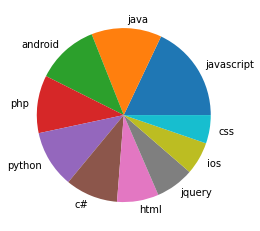

In [ ]:
plt.pie(topten_trends.values,labels = topten_trends.index)
plt.show()

#Final Results : 

---



## Display Results

In [ ]:
so_users_and_responses = Final_Results

In [ ]:
so_users_and_responses

,Top 5 Users who can answer,50%-Response-time (mins),75%-Response-time (mins)
python,"100297,190597,20862,104349,771848",20.0,144.0
r,"1144035,100297,3732271,13302,771848",27.0,227.0
matlab,"2586922,97160,232610,3250829,2732801",37.0,191.0
sas,"1623007,1919583,214994,2734437,1652962",109.0,924.0
excel,"2474656,1505120,4039065,1140579,478884",37.0,185.0
sql,"1144035,491243,13302,939860,27535",13.0,63.0


In [ ]:
so_rules.reset_index(drop = True)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(sql, tsql)",(sql-server),0.011774,0.097320,0.008114,0.689122,7.080989,0.006968,2.903643
1,(python-3.x),(python),0.022626,0.346199,0.015461,0.683325,1.973796,0.007628,2.064585
2,(excel-vba),(excel),0.027883,0.055648,0.018510,0.663848,11.929378,0.016958,2.809298
3,(python-2.7),(python),0.030884,0.346199,0.019989,0.647232,1.869541,0.009297,1.853349
4,(tsql),(sql-server),0.022283,0.097320,0.014100,0.632756,6.501813,0.011931,2.457985
5,"(sql-server, sql-server-2008)",(sql),0.011152,0.191757,0.006608,0.592504,3.089871,0.004469,1.983437
6,"(sql-server, tsql)",(sql),0.014100,0.191757,0.008114,0.575447,3.000920,0.005410,1.903749
7,"(sql, sql-server-2008)",(sql-server),0.012465,0.097320,0.006608,0.530095,5.446926,0.005395,1.920982
8,(tsql),(sql),0.022283,0.191757,0.011774,0.528379,2.755465,0.007501,1.713756
9,(sql-server-2008),(sql),0.026259,0.191757,0.012465,0.474694,2.475500,0.007430,1.538614


In [ ]:
so_rules.head(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
27,"(sql, tsql)",(sql-server),0.011774,0.097320,0.008114,0.689122,7.080989,0.006968,2.903643
8,(python-3.x),(python),0.022626,0.346199,0.015461,0.683325,1.973796,0.007628,2.064585
1,(excel-vba),(excel),0.027883,0.055648,0.018510,0.663848,11.929378,0.016958,2.809298


**Note : antecedents and consequents are Frozen set and failing to write to a DB, hence converting them to list**

In [ ]:
so_rules = (so_rules.explode('antecedents')
         .reset_index(drop=True)
         .explode('consequents')
         .reset_index(drop=True))

In [ ]:
antecedentslst=[]
for item in so_rules.antecedents:
  antecedentslst.append(list(item))

In [ ]:
consequentslst=[]
for item in so_rules.consequents:
  consequentslst.append(list(item))

In [ ]:
so_rules['antecedents'] = antecedentslst 
so_rules['consequents'] = consequentslst

In [ ]:
so_rules.head(5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"[sql, tsql]",[sql-server],0.011774,0.097320,0.008114,0.689122,7.080989,0.006968,2.903643
1,[python-3.x],[python],0.022626,0.346199,0.015461,0.683325,1.973796,0.007628,2.064585
2,[excel-vba],[excel],0.027883,0.055648,0.018510,0.663848,11.929378,0.016958,2.809298
3,[python-2.7],[python],0.030884,0.346199,0.019989,0.647232,1.869541,0.009297,1.853349
4,[tsql],[sql-server],0.022283,0.097320,0.014100,0.632756,6.501813,0.011931,2.457985


# Store to RDS Database

## First DB 
to store Top 5 users to notify and provide a approxmate time range ( Between 50% to 75% percentile)

In [ ]:
host1='test-instance1.cpuhpqgnujqo.us-east-1.rds.amazonaws.com'
port1=int(3306)
user='master'
passw='soassignment'
database1='top_5_id_and_response_time'

mydb1 = create_engine('mysql+pymysql://' + user + ':' + passw + '@' + host1 + ':' + str(port1) + '/' + database1 , echo=False)

## Seconds DB
to Store the Rules of predictive Tags , More tags can give faster response with wider audience

In [ ]:
host2='test-instance-2.cpuhpqgnujqo.us-east-1.rds.amazonaws.com'
port2=int(3306)
user='master'
passw='soassignment'
database2='so_rules_predictive_tag'

mydb2 = create_engine('mysql+pymysql://' + user + ':' + passw + '@' + host2 + ':' + str(port2) + '/' + database2 , echo=False)

In [ ]:
so_users_and_responses.to_sql(name="top_5_id_and_response_time", con=mydb1, if_exists='replace', index=False) 

In [ ]:
so_rules.to_sql(name="so_rules_predictive_tag", con=mydb2, if_exists='replace', index=False) 

**Note: Have deleted RDS now.** 

---



#         Complete

---

